<a href="https://colab.research.google.com/github/lingliao/Machine-learning-model/blob/main/cnn%20for%20genomic%20sequence%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scanpy==1.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  #print(sequence)
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  #print(integer_encoded)
  # Below converts to a 2D array with one column and as many rows as needed.
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  #print(integer_encoded)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  #print(one_hot_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
# The transposed output will have one row for each DNA letter
print('One hot encoding of Sequence #1:\n',input_features[0].T)
input_features.shape

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(2000, 50, 4)

In [5]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

#one_hot_encoder = OneHotEncoder(categories='auto')
input_labels = np.array(labels)
#input_labels = one_hot_encoder.fit_transform(labels).toarray()
input_labels.shape
#print('Labels:\n',labels.T)
#print('One-hot encoded labels:\n',input_labels.T)

(2000,)

In [6]:
train_x, val_x, train_y, val_y = train_test_split(input_features, input_labels, test_size = 0.25, random_state=42)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((1500, 50, 4), (1500,)), ((500, 50, 4), (500,)))

In [7]:
train_x = train_x.reshape(1500, 1, 50, 4)
train_x  = torch.from_numpy(train_x)
#train_x = train_x.to(torch.int64)


# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)
#train_y = train_y.to(torch.int64)

#train_dat = torch.utils.data.TensorDataset(torch.tensor(train_x).to(device), torch.tensor(train_y).to(device))

# shape of training data
train_x.dtype, train_x.shape, train_y.shape

(torch.float64, torch.Size([1500, 1, 50, 4]), torch.Size([1500]))

In [8]:
train_x = train_x.to(torch.float32)
(train_x.dtype, train_y.dtype)


(torch.float32, torch.int64)

In [9]:
val_x = val_x.reshape(500, 1, 50, 4)
val_x  = torch.from_numpy(val_x)
val_x = val_x.to(torch.int64)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)
val_y = val_y.to(torch.int64)

# shape of validation data
val_x.dtype, val_y.dtype, val_x.shape, val_y.shape

(torch.int64, torch.int64, torch.Size([500, 1, 50, 4]), torch.Size([500]))

In [10]:
val_x = val_x.to(torch.float32)
val_x.dtype, val_y.dtype, (train_x.dtype, train_y.dtype)

(torch.float32, torch.int64, (torch.float32, torch.int64))

In [11]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            MaxPool2d(kernel_size=2, stride=2),
            ReLU(inplace=True),
            # Defining another 2D convolution layer
            #torch.nn.Dropout(p=.2),
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            #MaxPool2d(kernel_size=2, stride=2),
            ReLU(inplace=True),
        )

        self.linear_layers = Sequential(
            Linear(4 * 25 * 2, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [12]:
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.002)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=200, out_features=10, bias=True)
  )
)


In [13]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val )

In [14]:
n_epochs = 200
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.6186, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(2.0229, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(1.5336, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(1.1795, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(0.9627, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(0.8433, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(0.7754, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(0.7355, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  17 	 loss : tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  19 	 loss : tensor(0.7115, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  21 	 loss : tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  23 	 loss : tensor(0.7013, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  25 	 loss : tensor(0.689

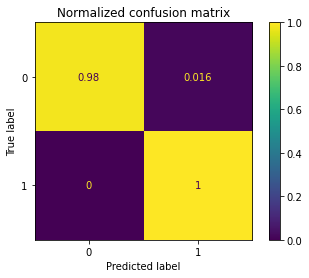

In [15]:
# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(train_y, predictions,normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.title('Normalized confusion matrix')
plt.show()


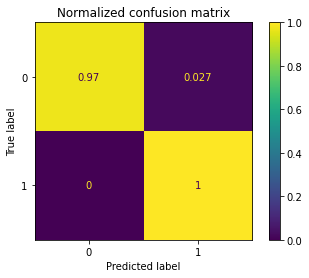

In [16]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)


confusion_matrix = metrics.confusion_matrix(val_y, predictions,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.title('Normalized confusion matrix')
plt.show()

In [17]:
test=[]
for i in range(len(train_losses)):
  test_=train_losses[i].data
  test.append(test_)
val=[]
for i in range(len(val_losses)):
  val_=val_losses[i].data
  val.append(val_)
print(val)

data_test=[]
for i in range(len(test)):
  data_test_=test[i].to("cpu").numpy()
  data_test.append(data_test_)

data_val=[]
for i in range(len(val)):
  data_val_=val[i].to("cpu").numpy()
  data_val.append(data_val_)
print(data_val)

[tensor(2.6186, device='cuda:0'), tensor(2.3099, device='cuda:0'), tensor(2.0229, device='cuda:0'), tensor(1.7626, device='cuda:0'), tensor(1.5336, device='cuda:0'), tensor(1.3386, device='cuda:0'), tensor(1.1795, device='cuda:0'), tensor(1.0557, device='cuda:0'), tensor(0.9627, device='cuda:0'), tensor(0.8940, device='cuda:0'), tensor(0.8433, device='cuda:0'), tensor(0.8050, device='cuda:0'), tensor(0.7754, device='cuda:0'), tensor(0.7527, device='cuda:0'), tensor(0.7355, device='cuda:0'), tensor(0.7236, device='cuda:0'), tensor(0.7165, device='cuda:0'), tensor(0.7129, device='cuda:0'), tensor(0.7115, device='cuda:0'), tensor(0.7106, device='cuda:0'), tensor(0.7090, device='cuda:0'), tensor(0.7059, device='cuda:0'), tensor(0.7013, device='cuda:0'), tensor(0.6956, device='cuda:0'), tensor(0.6898, device='cuda:0'), tensor(0.6845, device='cuda:0'), tensor(0.6802, device='cuda:0'), tensor(0.6771, device='cuda:0'), tensor(0.6746, device='cuda:0'), tensor(0.6722, device='cuda:0'), tensor(0.

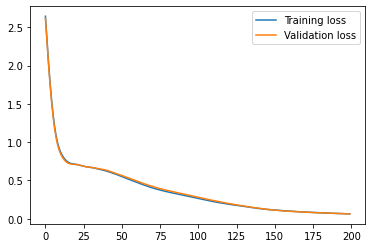

In [19]:
plt.plot(data_test, label='Training loss')
plt.plot(data_val, label='Validation loss')
plt.legend()
#plt.axis([0, 200, 0, 0.6])
plt.show()